In [3]:
import pandas as pd
import glob
import os

base_folder = r"C:\Users\lzscs\Desktop\Bubi"
years = ["2022", "2023", "2024"]

dfs = []

# Regex a helyes formátumú helyazonosítókhoz
pattern = r'^\d{4}-'

for year in years:
    folder_path = os.path.join(base_folder, year)
    file_list = glob.glob(os.path.join(folder_path, "*.xlsx"))
    print(f"{year}: {len(file_list)} fájl található")

    for file in file_list:
        print("Beolvasás:", file)
        temp_df = pd.read_excel(file)
        temp_df["year"] = int(year)

        # Már itt szűrünk — csak azokat tartsuk meg, ahol a helyazonosítók jók
        mask = (
            temp_df['start_place_id'].astype(str).str.match(pattern) &
            temp_df['end_place_id'].astype(str).str.match(pattern)
        )
        temp_df = temp_df[mask]

        # Csak a releváns oszlopokat tartsuk meg (opcionális gyorsítás)
        cols = ['start_time', 'end_time', 'duration', 'start_place_id', 'end_place_id',
                'start_lat', 'start_lng', 'end_lat', 'end_lng',
                'cust_id', 'bike_id', 'coupon_name', 'year']
        temp_df = temp_df[cols]

        dfs.append(temp_df)

# Összefűzés
df = pd.concat(dfs, ignore_index=True)
print("Összes sor beolvasva és szűrve:", len(df))

# Dátumkonverzió
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')
df = df.dropna(subset=['start_time', 'end_time'])

# Időtartam percben
df['duration_min'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60
df = df[(df['duration_min'] > 0) & (df['duration_min'] < 120)]

# Statisztikák
print("Utazások száma:", len(df))
print("Átlagos utazási idő (perc):", df['duration_min'].mean().round(2))
print("Medián utazási idő (perc):", df['duration_min'].median().round(2))

df['hour'] = df['start_time'].dt.hour
traffic_by_hour = df.groupby('hour').size()
print("\nÓránkénti utazások száma:")
print(traffic_by_hour)

df['month'] = df['start_time'].dt.month
traffic_by_month = df.groupby(['year', 'month']).size()
print("\nHónaponkénti utazások száma (évenként):")
print(traffic_by_month)


2022: 12 fájl található
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_01.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_02.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_03.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_04.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_05.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_06.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_07.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_08.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_09.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_10.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_11.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2022\2022_12.xlsx
2023: 10 fájl található
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2023\2023_01.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2023\2023_02.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2023\2023_03.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2023\2023_04.xlsx
Beolvasás: C:\Users\lzscs\Desktop\Bubi\2

In [6]:
df.to_pickle("bubi_all_years.pkl")

In [1]:
import pandas as pd
df = pd.read_pickle("bubi_all_years.pkl")

In [2]:
# 1. Hány utazás indult / érkezett egy állomásról
start_counts = df.groupby('start_place_id').size().reset_index(name='indulások')
end_counts = df.groupby('end_place_id').size().reset_index(name='érkezések')

# 2. Kettő összevonása: teljes forgalom (indulás + érkezés)
station_traffic = pd.merge(start_counts, end_counts,
                           left_on='start_place_id', right_on='end_place_id',
                           how='outer')

# 3. Az azonosítókat és forgalmat rendezzük
station_traffic['állomás'] = station_traffic['start_place_id'].combine_first(station_traffic['end_place_id'])
station_traffic['összes_forgalom'] = station_traffic['indulások'].fillna(0) + station_traffic['érkezések'].fillna(0)

# 4. Legforgalmasabb állomások kilistázása
top_stations = station_traffic.sort_values('összes_forgalom', ascending=False).head(10)
print(top_stations[['állomás', 'összes_forgalom']])

                    állomás  összes_forgalom
182    1301-Jászai Mari tér         306910.0
185       1304-Margitsziget         276808.0
95       0812-Corvin sétány         261154.0
114         0905-Kálvin tér         235248.0
46           0515-Fővám tér         234058.0
137  1101-Szent Gellért tér         221527.0
86         0804-Rákóczi tér         204584.0
0        0101-Batthyány tér         201485.0
56             0607-Oktogon         200817.0
90   0808-Keleti pályaudvar         190086.0


In [6]:
# Bérlettípusok aránya évenként
license_share = df.groupby(['year', 'coupon_name']).size().reset_index(name='utazások')
license_share['arány (%)'] = (license_share['utazások'] / license_share.groupby('year')['utazások'].transform('sum') * 100).round(2)
print(license_share)

    year                             coupon_name  utazások  arány (%)
0   2022                            3 havi kupon       538       0.02
1   2022                       3 havi kupon komp        60       0.00
2   2022                              Havi Kupon       588       0.02
3   2022                             Havi bérlet   1903902      79.22
4   2022                              Havi kupon      9795       0.41
5   2022                                    PAYG    205653       8.56
6   2022                             Éves Bérlet     60999       2.54
7   2022                             Éves bérlet    190584       7.93
8   2022                              Éves kupon     31207       1.30
9   2023                            3 havi kupon      5743       0.21
10  2023                             Havi bérlet   1810245      64.71
11  2023                              Havi kupon     14682       0.52
12  2023  MOL Bubi x ÉnBudapest App - Subvoucher         1       0.00
13  2023            

In [8]:
import folium

# Állomások koordinátáinak átlaga (ha vannak külön induló és érkező koordináták)
station_coords = df.groupby('start_place_id')[['start_lat', 'start_lng']].mean().reset_index()
station_coords.rename(columns={'start_place_id': 'állomás'}, inplace=True)

# Forgalom hozzáadása
station_map_data = pd.merge(station_coords, station_traffic, on='állomás', how='left')

# Térkép létrehozása
m = folium.Map(location=[47.4979, 19.0402], zoom_start=12)

# Körök elhelyezése állomásonként
for _, row in station_map_data.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=row['összes_forgalom'] / 100000,  # a méretet skálázni kell
        color='blue',
        fill=True,
        fill_opacity=0.5,
        popup=f"{row['állomás']} – {int(row['összes_forgalom'])} utazás"
    ).add_to(m)

# Mentés
m.save("bubi_allomasok_forgalma.html")

In [9]:
import webbrowser
webbrowser.open("bubi_allomasok_forgalma.html")

ERROR: Could not find a version that satisfies the requirement wbbrowser (from versions: none)
ERROR: No matching distribution found for wbbrowser


True

In [10]:
import folium
import pandas as pd
from branca.element import Template, MacroElement
from difflib import get_close_matches

# --- Állomáscsaládok (végleges lista) ---
families = {
    "Csonka János tér (2022-06)": [
        "Csonka János tér"
    ],
    "Zuglói csoport (2023-06)": [
        "Egressy út – Stefánia út",
        "Stefánia út – Thököly út",
        "Zugló vasútállomás",
        "Kacsóh Pongrác út",
        "Papp László Budapest Sportaréna",
        "Reiner Frigyes park"
    ],
    "9. kerület (2023-09)": [
        "Mester utca – Ferenc körút",
        "Haller utca – Mester utca",
        "Nádasdy utca",
        "Haller utca – Soroksári út"
    ],
    "Kopaszi-gát (2024-04)": [
        "Kopaszi-gát"
    ],
    "Westend – Balzac utca (2024-05)": [
        "Westend – Balzac utca"
    ]
}

colors = ["blue", "purple", "orange", "green", "darkred"]

# --- Előkészítés ---
places = (
    df[['end_place_id', 'end_lat', 'end_lng']]
    .dropna(subset=['end_place_id', 'end_lat', 'end_lng'])
    .copy()
)
places['end_place_id'] = places['end_place_id'].astype(str).str.strip()

# --- Állomáskoordináták pontosítása fuzzy kereséssel ---
unique_places = places['end_place_id'].unique().tolist()
family_stations = {}

for i, (fam_name, target_names) in enumerate(families.items()):
    color = colors[i % len(colors)]
    stations = {}

    for target in target_names:
        match = get_close_matches(target, unique_places, n=1, cutoff=0.6)
        if match:
            place_name = match[0]
            coords = places.loc[places['end_place_id'] == place_name, ['end_lat', 'end_lng']].iloc[0]
            stations[place_name] = {'lat': float(coords['end_lat']), 'lng': float(coords['end_lng'])}
        else:
            print(f"⚠️ Nem található hasonló állomás: {target}")

    family_stations[fam_name] = {"color": color, "stations": stations}

# --- Térkép középpont ---
all_coords = [
    (s['lat'], s['lng'])
    for fam in family_stations.values()
    for s in fam['stations'].values()
]
avg_lat = sum([c[0] for c in all_coords]) / len(all_coords)
avg_lng = sum([c[1] for c in all_coords]) / len(all_coords)

m = folium.Map(location=[avg_lat, avg_lng], zoom_start=13)

# --- Jelölők felhelyezése ---
for fam_name, info in family_stations.items():
    color = info['color']
    for station_name, s in info['stations'].items():
        folium.CircleMarker(
            location=[s['lat'], s['lng']],
            radius=7,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.9,
            popup=f"<b>{station_name}</b><br><i>{fam_name}</i>"
        ).add_to(m)

# --- Legenda ---
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 250px;
    z-index:9999;
    font-size:14px;
    ">
    <div style="background-color: white; padding: 10px; border:2px solid grey;">
        <b>Állomáscsaládok legendája</b><br>
        <hr style="margin:6px 0;">
"""
for fam_name, info in family_stations.items():
    legend_html += f'<i style="background:{info["color"]};width:12px;height:12px;display:inline-block;margin-right:8px;"></i>{fam_name}<br>'
legend_html += """
    </div>
</div>
{% endmacro %}
"""
template = Template(legend_html)
macro = MacroElement()
macro._template = template
m.get_root().add_child(macro)

# --- Mentés ---
m.save("allomascsaladok_map.html")
m



⚠️ Nem található hasonló állomás: Nádasdy utca


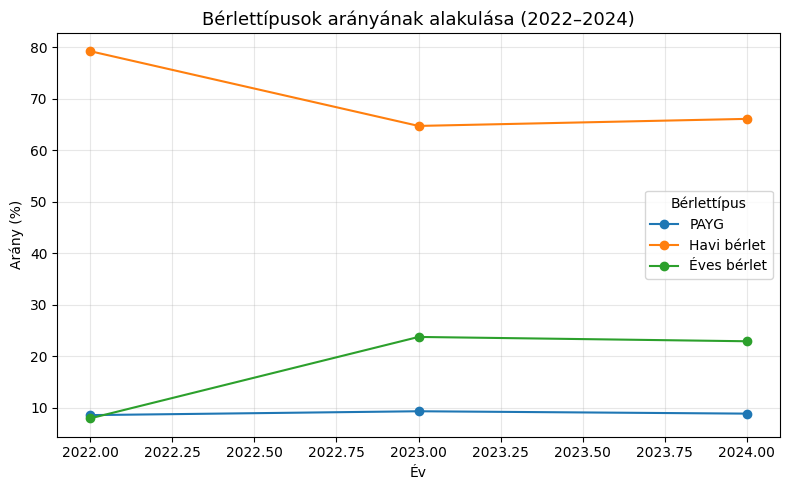

In [14]:
import matplotlib.pyplot as plt

# Főbb bérlettípusok
fobb_tipusok = ["PAYG", "Havi bérlet", "Éves bérlet"]

plt.figure(figsize=(8, 5))

for tipus in fobb_tipusok:
    subset = license_share[license_share['coupon_name'] == tipus]
    plt.plot(subset['year'], subset['arány (%)'], marker='o', label=tipus)

plt.title("Bérlettípusok arányának alakulása (2022–2024)", fontsize=13)
plt.xlabel("Év")
plt.ylabel("Arány (%)")
plt.legend(title="Bérlettípus", loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
print(df.columns.tolist())

['uid', 'start_time', 'end_time', 'duration', 'start_place_id', 'end_place_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'cust_id', 'bike_name', 'termek.Termék', 'year', 'coupon_name', 'bike_id', 'Bike number', 'Termek', 'bike_number', 'duration_min', 'hour', 'month']


A legközelebbi 15 állomás a zuglói állomáscsoporthoz:
                                   station_name  distance_to_zuglo
58                               0703-Garay tér           0.310062
193     1405-Zichy Géza utca – Ajtósi Dürer sor           0.413376
99                         1401-Széchenyi fürdő           0.475992
231            0826-Arena Mall bevásárlóközpont           0.537119
14       0702-Dózsa György út - Dembinszky utca           0.574786
68         1402-Vágány utca-Róbert Károly körút           0.590364
62                       0808-Keleti pályaudvar           0.607136
192      1404-Olof Palme sétány - Dvořák sétány           0.740320
60               1322-Rákosrendező vasútállomás           0.770759
191  1403-Városligeti Műjégpálya és Csónakázótó           0.776328
20                       0711-Bethlen Gábor tér           0.789945
27                              0602-Hősök tere           0.957243
118    0612-Városligeti fasor - Dózsa György út           0.994437
95      

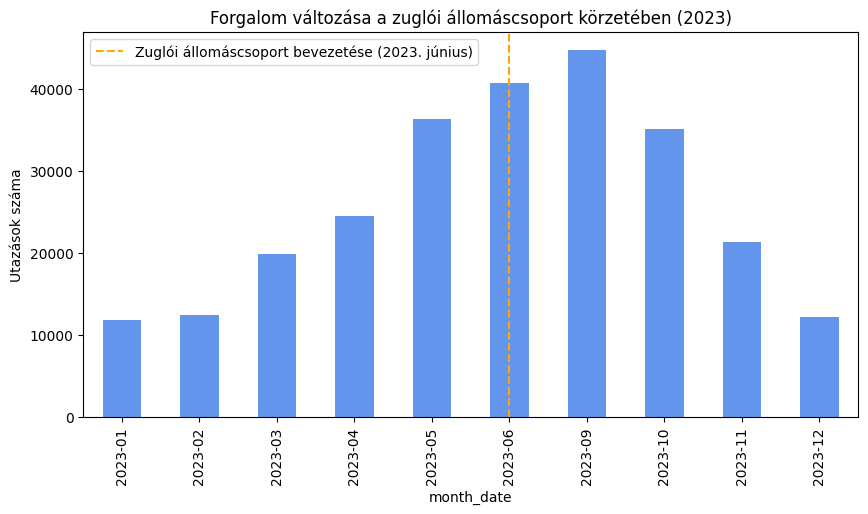

In [3]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# --- 1️⃣ Zuglói állomáscsalád definiálása ---
zuglo_stations = [
    "1406-Egressy út - Stefánia út",
    "1407-Stefánia út - Thököly út",
    "1408-Zugló vasútállomás",
    "1409-Kacsóh Pongrác út",
    "1410-Papp László Budapest Sportaréna",
    "1411-Reiner Frigyes park"
]

# --- 2️⃣ Kiválogatjuk az összes állomást (start + end) ---
start_stations = df[['start_place_id', 'start_lat', 'start_lng']].dropna().drop_duplicates()
start_stations.columns = ['station_name', 'lat', 'lng']

end_stations = df[['end_place_id', 'end_lat', 'end_lng']].dropna().drop_duplicates()
end_stations.columns = ['station_name', 'lat', 'lng']

all_stations = pd.concat([start_stations, end_stations]).drop_duplicates(subset=['station_name']).reset_index(drop=True)

# --- 3️⃣ Csak valódi állomások maradjanak ---
all_stations = all_stations[~all_stations['station_name'].str.startswith(("BIKE", "recording"))]

# --- 4️⃣ Zuglói állomások koordinátái ---
zuglo_coords = all_stations[all_stations['station_name'].isin(zuglo_stations)][['lat', 'lng']].values
if len(zuglo_coords) == 0:
    raise ValueError("Nem találhatók a zuglói állomások a df-ben!")

# --- 5️⃣ Távolság kiszámítása minden állomás és a zuglóiak között ---
def min_distance_to_zuglo(row):
    distances = [geodesic((row['lat'], row['lng']), (zc[0], zc[1])).km for zc in zuglo_coords]
    return min(distances)

all_stations['distance_to_zuglo'] = all_stations.apply(min_distance_to_zuglo, axis=1)

# --- 6️⃣ A legközelebbi 15 másik állomás (kizárva a zuglóiakat) ---
nearest_stations = (
    all_stations[~all_stations['station_name'].isin(zuglo_stations)]
    .nsmallest(15, 'distance_to_zuglo')
)

print("A legközelebbi 15 állomás a zuglói állomáscsoporthoz:")
print(nearest_stations[['station_name', 'distance_to_zuglo']])

# --- 7️⃣ Forgalom szűrése a körzetre ---
mask = (
    df['start_place_id'].isin(nearest_stations['station_name'])
    | df['end_place_id'].isin(nearest_stations['station_name'])
)
df_nearby = df[mask].copy()
df_nearby = df_nearby.dropna(subset=['start_time'])

# --- 8️⃣ Havi forgalom ---
df_nearby['month_date'] = pd.to_datetime(df_nearby['start_time']).dt.to_period('M')
traffic_by_month = df_nearby.groupby('month_date').size()

# --- 9️⃣ Összehasonlítás: bevezetés előtti vs utáni időszak ---
before = traffic_by_month['2023-03':'2023-05'].sum()
after = traffic_by_month['2023-07':'2023-09'].sum()

if before == 0:
    print(f"\n📊 Forgalom 3 hónappal előtte: {before} (nem volt adat)")
    print(f"📈 Forgalom 3 hónappal utána: {after:,}")
    print("Változás: nem értelmezhető (előtte 0 utazás)")
else:
    change_ratio = (after / before - 1) * 100
    print(f"\n📊 Forgalom 3 hónappal előtte: {before:,}")
    print(f"📈 Forgalom 3 hónappal utána: {after:,}")
    print(f"Változás: {change_ratio:.2f}%")

# --- 🔟 Vizualizáció ---
plt.figure(figsize=(10,5))
ax = traffic_by_month['2023-01':'2023-12'].plot(kind='bar', color='cornflowerblue')

# Bevezetés hónap
open_month = pd.Period('2023-06', freq='M')
x_pos = traffic_by_month['2023-01':'2023-12'].index.get_indexer([open_month])[0]
plt.axvline(x=x_pos, color='orange', linestyle='--', label='Zuglói állomáscsoport bevezetése (2023. június)')

plt.title("Forgalom változása a zuglói állomáscsoport körzetében (2023)")
plt.ylabel("Utazások száma")
plt.legend()
plt.show()


A legközelebbi 15 állomás a 9. kerületi állomáscsoporthoz:
                                   station_name  distance_to_district9
155                             0908-Bakáts tér               0.179824
226                0926-Metrodom - Vaskapu utca               0.190561
131                              0912-MILL Park               0.291158
221        0912-Tóth Kálmán utca - Soroksári út               0.291158
108             0918-Liliom utca - Tűzoltó utca               0.308932
23                             0904-Boráros tér               0.323299
227  0925-K&H Bank székház - Lechner Ödön fasor               0.336733
36                              0906-Ferenc tér               0.383276
11                 0902-Üllői út - Ferenc Körút               0.451058
209                          0920-Budapest Park               0.458150
82               0911-Ráday utca - Kinizsi utca               0.472975
211              0922-Haller utca – Mester utca               0.483730
140               

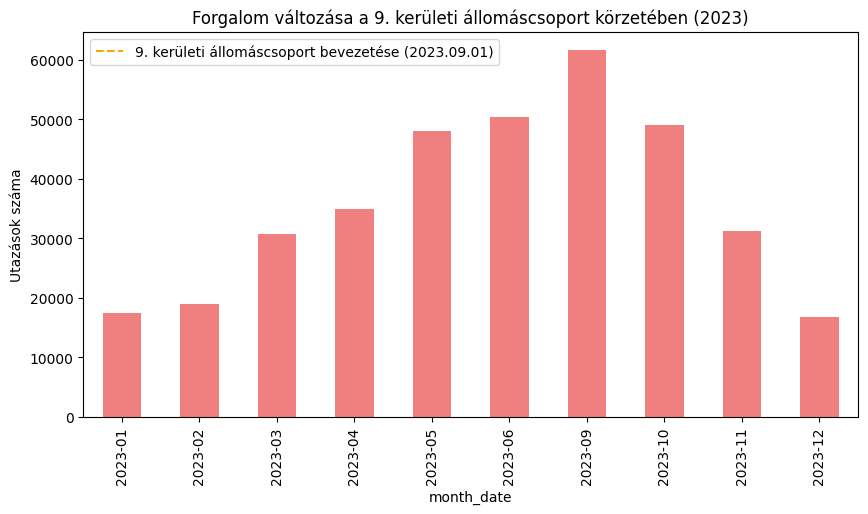

In [13]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# --- 1️⃣ 9. kerületi állomáscsalád definiálása ---
district9_stations = [
    "0921-Mester utca - Ferenc körút",
    "0922-Haller utca - Mester utca",
    "0923-Nádasdy utca (játszótér)",
    "0924-Haller utca - Soroksári út"
]

# --- 2️⃣ Kiválogatjuk az összes állomást (start + end) ---
start_stations = df[['start_place_id', 'start_lat', 'start_lng']].dropna().drop_duplicates()
start_stations.columns = ['station_name', 'lat', 'lng']

end_stations = df[['end_place_id', 'end_lat', 'end_lng']].dropna().drop_duplicates()
end_stations.columns = ['station_name', 'lat', 'lng']

all_stations = pd.concat([start_stations, end_stations]).drop_duplicates(subset=['station_name']).reset_index(drop=True)

# --- 3️⃣ Csak valódi állomások maradjanak ---
all_stations = all_stations[~all_stations['station_name'].str.startswith(("BIKE", "recording"))]

# --- 4️⃣ 9. kerületi állomások koordinátái ---
district9_coords = all_stations[all_stations['station_name'].isin(district9_stations)][['lat', 'lng']].values
if len(district9_coords) == 0:
    raise ValueError("Nem találhatók a 9. kerületi állomások a df-ben!")

# --- 5️⃣ Távolság kiszámítása minden állomás és a 9. kerületi állomások között ---
def min_distance_to_district9(row):
    distances = [geodesic((row['lat'], row['lng']), (c[0], c[1])).km for c in district9_coords]
    return min(distances)

all_stations['distance_to_district9'] = all_stations.apply(min_distance_to_district9, axis=1)

# --- 6️⃣ A legközelebbi 15 másik állomás (kizárva a 9. kerületi állomásokat) ---
nearest_stations = (
    all_stations[~all_stations['station_name'].isin(district9_stations)]
    .nsmallest(15, 'distance_to_district9')
)

print("A legközelebbi 15 állomás a 9. kerületi állomáscsoporthoz:")
print(nearest_stations[['station_name', 'distance_to_district9']])

# --- 7️⃣ Forgalom szűrése a körzetre ---
mask = (
    df['start_place_id'].isin(nearest_stations['station_name'])
    | df['end_place_id'].isin(nearest_stations['station_name'])
)
df_nearby = df[mask].copy()
df_nearby = df_nearby.dropna(subset=['start_time'])

# --- 8️⃣ Havi forgalom ---
df_nearby['month_date'] = pd.to_datetime(df_nearby['start_time']).dt.to_period('M')
traffic_by_month = df_nearby.groupby('month_date').size()

# --- 9️⃣ Összehasonlítás: bevezetés előtti vs utáni időszak ---
launch_date = pd.Period('2023-09', freq='M')  # bevezetés hónapja: szeptember 2023

# Előtte: 3 hónap (június, július, augusztus)
before = traffic_by_month['2023-06':'2023-08'].sum()

# Utána: 3 hónap (szeptember, október, november)
after = traffic_by_month['2023-09':'2023-11'].sum()

if before == 0:
    print(f"\n📊 Forgalom 3 hónappal előtte: {before} (nem volt adat)")
    print(f"📈 Forgalom 3 hónappal utána: {after:,}")
    print("Változás: nem értelmezhető (előtte 0 utazás)")
else:
    change_ratio = (after / before - 1) * 100
    print(f"\n📊 Forgalom 3 hónappal előtte (2023-06 – 2023-08): {before:,}")
    print(f"📈 Forgalom 3 hónappal utána (2023-09 – 2023-11): {after:,}")
    print(f"Változás: {change_ratio:.2f}%")

# --- 🔟 Vizualizáció ---
plt.figure(figsize=(10,5))
ax = traffic_by_month['2023-01':'2023-12'].plot(kind='bar', color='lightcoral')

# Bevezetés hónap jelzése
x_pos = traffic_by_month.index.get_indexer([launch_date])[0]
plt.axvline(x=x_pos, color='orange', linestyle='--', label='9. kerületi állomáscsoport bevezetése (2023.09.01)')

plt.title("Forgalom változása a 9. kerületi állomáscsoport körzetében (2023)")
plt.ylabel("Utazások száma")
plt.legend()
plt.show()


Célállomás: Westend – Balzac utca
Koordináták: (np.float64(47.5127960215304), np.float64(19.0576929227741))

A legközelebbi 15 valódi állomás a célállomáshoz:
                                     station_name  distance_to_target
128                                  0614-Westend            0.000000
214                         1325-EY - Váci út 20.            0.116536
78                        0603-Nyugati pályaudvar            0.170786
222                    0620-Westend - Balzac utca            0.198400
47                               0611-Nyugati tér            0.390694
182  0617-Nyugati pályaudvar M (Podmaniczky utca)            0.409319
133    1305-Pannónia utca - Raoul Wallenberg utca            0.431770
89          0613-Ferdinánd híd - Podmaniczky utca            0.470944
100          0501-Szent István körút - Vígszínház            0.483104
184              0618-Szondi utca – Izabella utca            0.547911
44                 0605-Teréz körút - Szondi utca            0.578890
3

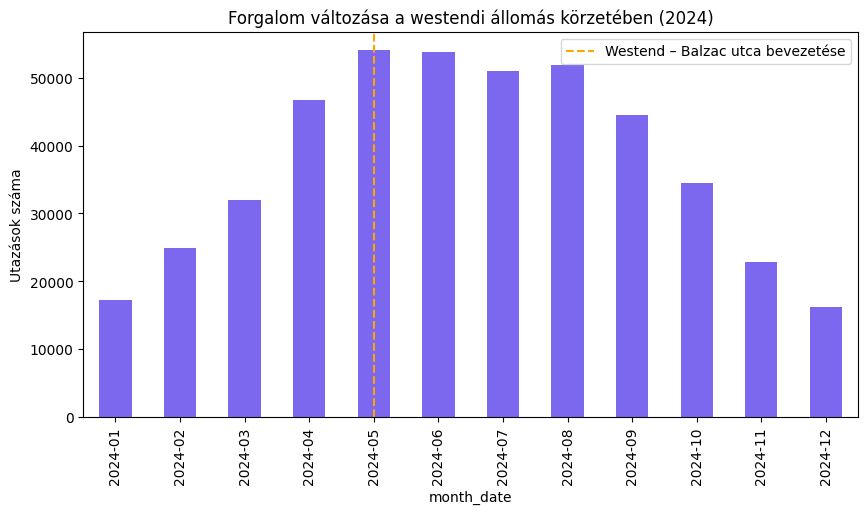

In [14]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# --- 1️⃣ Célállomás beállítása ---
target_station = "Westend – Balzac utca"

# Keressük az állomás koordinátáit a df-ből
target_row = df[df['start_place_id'].str.contains("Westend", case=False, na=False)].head(1)
if len(target_row) == 0:
    raise ValueError(f"Nem található a {target_station} állomás a df-ben!")

target_coords = (target_row['start_lat'].iloc[0], target_row['start_lng'].iloc[0])
print(f"Célállomás: {target_station}\nKoordináták: {target_coords}")

# --- 2️⃣ Kiválogatjuk az összes állomást a df-ből (start + end) ---
start_stations = df[['start_place_id', 'start_lat', 'start_lng']].dropna().drop_duplicates()
start_stations.columns = ['station_name', 'lat', 'lng']

end_stations = df[['end_place_id', 'end_lat', 'end_lng']].dropna().drop_duplicates()
end_stations.columns = ['station_name', 'lat', 'lng']

all_stations = pd.concat([start_stations, end_stations]).drop_duplicates(subset=['station_name']).reset_index(drop=True)

# --- 3️⃣ Csak valódi állomások (nem BIKE vagy recording) ---
all_stations = all_stations[~all_stations['station_name'].str.startswith(("BIKE", "recording"))]

# --- 4️⃣ Távolság a célállomástól ---
all_stations['distance_to_target'] = all_stations.apply(
    lambda row: geodesic(target_coords, (row['lat'], row['lng'])).km, axis=1
)

# --- 5️⃣ 15 legközelebbi állomás ---
nearest_stations = all_stations.nsmallest(15, 'distance_to_target')
print(f"\nA legközelebbi 15 valódi állomás a célállomáshoz:")
print(nearest_stations[['station_name', 'distance_to_target']])

# --- 6️⃣ Szűrés az utazásokra a körzetben ---
mask = df['start_place_id'].isin(nearest_stations['station_name']) | df['end_place_id'].isin(nearest_stations['station_name'])
df_nearby = df[mask].copy()
df_nearby = df_nearby.dropna(subset=['start_time'])

# --- 7️⃣ Forgalom hónaponként ---
df_nearby['month_date'] = pd.to_datetime(df_nearby['start_time']).dt.to_period('M')
traffic_by_month = df_nearby.groupby('month_date').size()

# --- 8️⃣ Összehasonlítás: előtte vs utána ---
launch_month = pd.Period('2024-05', freq='M')  # Westend – Balzac utca nyitás
before = traffic_by_month['2024-02':'2024-04'].sum()  # előtte 3 hónap
after = traffic_by_month['2024-05':'2024-07'].sum()   # utána 3 hónap

if before == 0:
    print(f"\n📊 Forgalom 3 hónappal előtte: {before} (nem volt adat)")
    print(f"📈 Forgalom 3 hónappal utána: {after:,}")
    print("Változás: nem értelmezhető (előtte 0 utazás)")
else:
    change_ratio = (after / before - 1) * 100
    print(f"\n📊 Forgalom 3 hónappal előtte (2024-02 – 2024-04): {before:,}")
    print(f"📈 Forgalom 3 hónappal utána (2024-05 – 2024-07): {after:,}")
    print(f"Változás: {change_ratio:.2f}%")

# --- 9️⃣ Vizualizáció ---
plt.figure(figsize=(10,5))
ax = traffic_by_month['2024-01':'2024-12'].plot(kind='bar', color='mediumslateblue')

# Szaggatott vonal a nyitás hónapjánál
x_pos = traffic_by_month['2024-01':'2024-12'].index.get_indexer([launch_month])[0]
plt.axvline(x=x_pos, color='orange', linestyle='--', label=f'{target_station} bevezetése')

plt.title(f"Forgalom változása a westendi állomás körzetében ({launch_month.year})")
plt.ylabel("Utazások száma")
plt.legend()
plt.show()


Célállomás: Csonka János tér
Koordináták: (np.float64(47.4706913250278), np.float64(19.0455039492422))

A legközelebbi 15 valódi állomás a célállomáshoz:
                                  station_name  distance_to_target
180                      1128-Csonka János tér            0.000000
178  1130-Hauszmann Alajos utca - Fehérvári út            0.383213
63                       1109-Újbuda-központ M            0.420235
219    1135-Hauszmann Alajos utca - Szerémi út            0.570344
179    1129-Bogdánfy utca - Neumann János utca            0.594919
113     1106-Budafoki út - Schönherz Kollégium            0.610184
30                  1111-Kosztolányi Dezső tér            0.621025
132                    1105-Kőrösy József utca            0.630059
75                 1107-Móricz Zsigmond körtér            0.732904
216     1132-Budafoki út - Karinthy Frigyes út            0.822081
175                     1126-Szent Imre Kórház            0.907633
218               1136-Etele út - Fehérvár

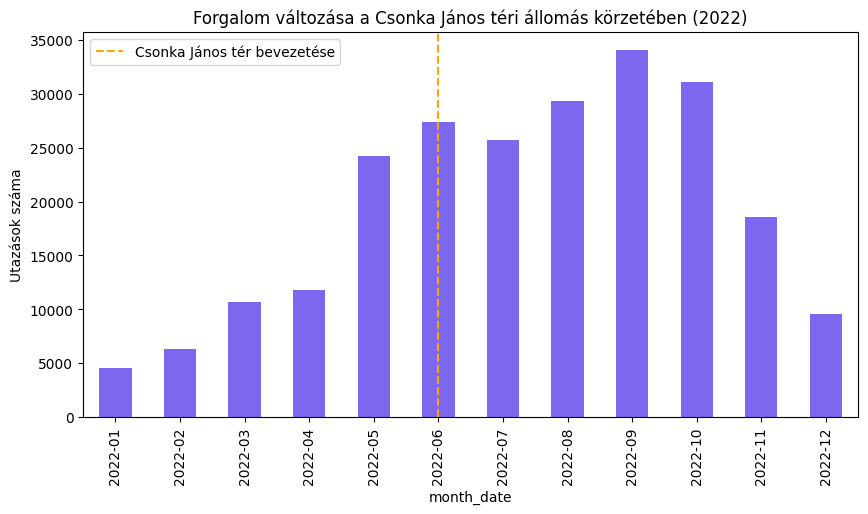

In [17]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# --- 1️⃣ Célállomás beállítása ---
target_station = "Csonka János tér"

# Keressük az állomás koordinátáit a df-ből
target_row = df[df['start_place_id'].str.contains("Csonka János", case=False, na=False)].head(1)
if len(target_row) == 0:
    raise ValueError(f"Nem található a {target_station} állomás a df-ben!")

target_coords = (target_row['start_lat'].iloc[0], target_row['start_lng'].iloc[0])
print(f"Célállomás: {target_station}\nKoordináták: {target_coords}")

# --- 2️⃣ Kiválogatjuk az összes állomást a df-ből (start + end) ---
start_stations = df[['start_place_id', 'start_lat', 'start_lng']].dropna().drop_duplicates()
start_stations.columns = ['station_name', 'lat', 'lng']

end_stations = df[['end_place_id', 'end_lat', 'end_lng']].dropna().drop_duplicates()
end_stations.columns = ['station_name', 'lat', 'lng']

all_stations = pd.concat([start_stations, end_stations]).drop_duplicates(subset=['station_name']).reset_index(drop=True)

# --- 3️⃣ Csak valódi állomások (nem BIKE vagy recording) ---
all_stations = all_stations[~all_stations['station_name'].str.startswith(("BIKE", "recording"))]

# --- 4️⃣ Távolság a célállomástól ---
all_stations['distance_to_target'] = all_stations.apply(
    lambda row: geodesic(target_coords, (row['lat'], row['lng'])).km, axis=1
)

# --- 5️⃣ 15 legközelebbi állomás ---
nearest_stations = all_stations.nsmallest(15, 'distance_to_target')
print(f"\nA legközelebbi 15 valódi állomás a célállomáshoz:")
print(nearest_stations[['station_name', 'distance_to_target']])

# --- 6️⃣ Szűrés az utazásokra a körzetben ---
mask = df['start_place_id'].isin(nearest_stations['station_name']) | df['end_place_id'].isin(nearest_stations['station_name'])
df_nearby = df[mask].copy()
df_nearby = df_nearby.dropna(subset=['start_time'])

# --- 7️⃣ Forgalom hónaponként ---
df_nearby['month_date'] = pd.to_datetime(df_nearby['start_time']).dt.to_period('M')
traffic_by_month = df_nearby.groupby('month_date').size()

# --- 8️⃣ Összehasonlítás: előtte vs utána ---
launch_month = pd.Period('2022-06', freq='M')  # Csonka János tér nyitás
before = traffic_by_month['2022-03':'2022-05'].sum()  # előtte 3 hónap
after = traffic_by_month['2022-06':'2022-08'].sum()   # utána 3 hónap

if before == 0:
    print(f"\n📊 Forgalom 3 hónappal előtte: {before} (nem volt adat)")
    print(f"📈 Forgalom 3 hónappal utána: {after:,}")
    print("Változás: nem értelmezhető (előtte 0 utazás)")
else:
    change_ratio = (after / before - 1) * 100
    print(f"\n📊 Forgalom 3 hónappal előtte (2022-03 – 2022-05): {before:,}")
    print(f"📈 Forgalom 3 hónappal utána (2022-06 – 2022-08): {after:,}")
    print(f"Változás: {change_ratio:.2f}%")

# --- 9️⃣ Vizualizáció ---
plt.figure(figsize=(10,5))
ax = traffic_by_month['2022-01':'2022-12'].plot(kind='bar', color='mediumslateblue')

# Szaggatott vonal a nyitás hónapjánál
x_pos = traffic_by_month['2022-01':'2022-12'].index.get_indexer([launch_month])[0]
plt.axvline(x=x_pos, color='orange', linestyle='--', label=f'{target_station} bevezetése')

plt.title(f"Forgalom változása a Csonka János téri állomás körzetében ({launch_month.year})")
plt.ylabel("Utazások száma")
plt.legend()
plt.show()


Célállomás: Kopaszi-gát
Koordináták: (np.float64(47.4666807842259), np.float64(19.0637974090578))

A legközelebbi 15 valódi állomás a célállomáshoz:
                                   station_name  distance_to_target
220                            1137-Kopaszi-gát            0.000000
69                           1120-Budapart Gate            0.438053
80                     1119-Infopark - aluljáró            0.453403
158                        9010-Közbringa-Mini3            0.479008
127                 0909-MÜPA-Nemzeti Színház H            0.558887
130            1108-Pázmány Péter sétány - ELTE            0.729747
144                    1115-Műegyetem, Q épület            0.824740
227  0925-K&H Bank székház - Lechner Ödön fasor            0.875358
179     1129-Bogdánfy utca - Neumann János utca            0.884246
209                          0920-Budapest Park            0.948070
221        0912-Tóth Kálmán utca - Soroksári út            0.950680
131                              09

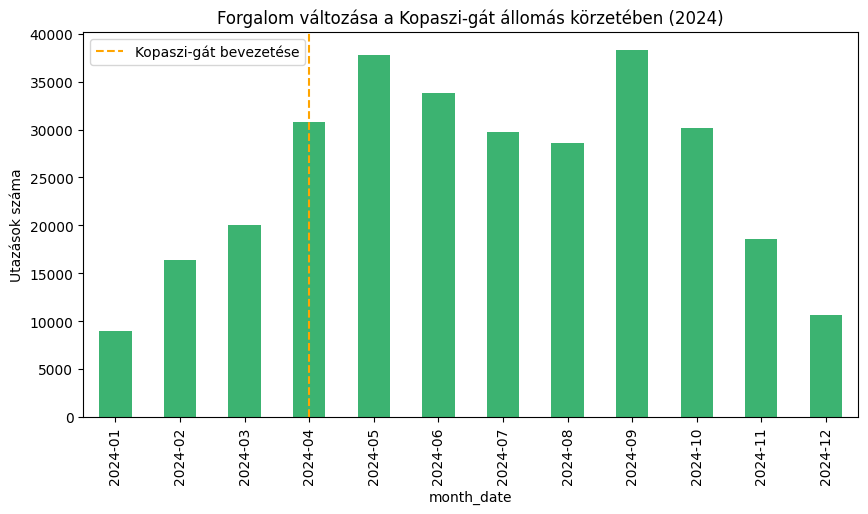

In [16]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# --- 1️⃣ Célállomás beállítása ---
target_station = "Kopaszi-gát"

# Keressük az állomás koordinátáit a df-ből
target_row = df[df['start_place_id'].str.contains("Kopaszi", case=False, na=False)].head(1)
if len(target_row) == 0:
    raise ValueError("Nem található a Kopaszi-gát állomás a df-ben!")

target_coords = (target_row['start_lat'].iloc[0], target_row['start_lng'].iloc[0])
print(f"Célállomás: {target_station}\nKoordináták: {target_coords}")

# --- 2️⃣ Kiválogatjuk az összes állomást a df-ből (start + end) ---
start_stations = df[['start_place_id', 'start_lat', 'start_lng']].dropna().drop_duplicates()
start_stations.columns = ['station_name', 'lat', 'lng']

end_stations = df[['end_place_id', 'end_lat', 'end_lng']].dropna().drop_duplicates()
end_stations.columns = ['station_name', 'lat', 'lng']

all_stations = pd.concat([start_stations, end_stations]).drop_duplicates(subset=['station_name']).reset_index(drop=True)

# --- 3️⃣ Csak valódi állomások (nem BIKE vagy recording) ---
all_stations = all_stations[~all_stations['station_name'].str.startswith(("BIKE", "recording"))]

# --- 4️⃣ Távolság a célállomástól ---
all_stations['distance_to_target'] = all_stations.apply(
    lambda row: geodesic(target_coords, (row['lat'], row['lng'])).km, axis=1
)

# --- 5️⃣ 15 legközelebbi állomás ---
nearest_stations = all_stations.nsmallest(15, 'distance_to_target')
print(f"\nA legközelebbi 15 valódi állomás a célállomáshoz:")
print(nearest_stations[['station_name', 'distance_to_target']])

# --- 6️⃣ Szűrés az utazásokra a körzetben ---
mask = df['start_place_id'].isin(nearest_stations['station_name']) | df['end_place_id'].isin(nearest_stations['station_name'])
df_nearby = df[mask].copy()
df_nearby = df_nearby.dropna(subset=['start_time'])

# --- 7️⃣ Forgalom hónaponként ---
df_nearby['month_date'] = pd.to_datetime(df_nearby['start_time']).dt.to_period('M')
traffic_by_month = df_nearby.groupby('month_date').size()

# --- 8️⃣ Összehasonlítás: előtte vs utána ---
before = traffic_by_month['2024-01':'2024-03'].sum()  # Április nyitás, előtte január-március
after = traffic_by_month['2024-04':'2024-06'].sum()   # Utána április-június

if before == 0:
    print(f"\n📊 Forgalom 3 hónappal előtte: {before} (nem volt adat)")
    print(f"📈 Forgalom 3 hónappal utána: {after:,}")
    print("Változás: nem értelmezhető (előtte 0 utazás)")
else:
    change_ratio = (after / before - 1) * 100
    print(f"\n📊 Forgalom 3 hónappal előtte: {before:,}")
    print(f"📈 Forgalom 3 hónappal utána: {after:,}")
    print(f"Változás: {change_ratio:.2f}%")

# --- 9️⃣ Vizualizáció (pontos szaggatott vonal) ---
plt.figure(figsize=(10,5))
ax = traffic_by_month['2024-01':'2024-12'].plot(kind='bar', color='mediumseagreen')

# Nyitás hónap indexének meghatározása
open_month = pd.Period('2024-04', freq='M')
x_pos = traffic_by_month['2024-01':'2024-12'].index.get_indexer([open_month])[0]

# Szaggatott vonal hozzáadása a megfelelő pozícióhoz
plt.axvline(x=x_pos, color='orange', linestyle='--', label=f'{target_station} bevezetése')

plt.title("Forgalom változása a Kopaszi-gát állomás körzetében (2024)")
plt.ylabel("Utazások száma")
plt.legend()
plt.show()


In [18]:
import pandas as pd

# --- Állomáscsoportok és megnyitási hónapjuk ---
station_groups = [
    {
        "name": "Csonka János tér",
        "station_ids": ["1128-Csonka János tér"],
        "open": "2022-06"
    },
    {
        "name": "Zuglói állomáscsoport",
        "station_ids": [
            "1406-Egressy út - Stefánia út",
            "1407-Stefánia út - Thököly út",
            "1408-Zugló vasútállomás",
            "1409-Kacsóh Pongrác út",
            "1410-Papp László Budapest Sportaréna",
            "1411-Reiner Frigyes park"
        ],
        "open": "2023-06"
    },
    {
        "name": "9. kerületi állomások",
        "station_ids": [
            "0921-Mester utca - Ferenc körút",
            "0922-Haller utca – Mester utca",
            "0923-Nádasdy utca (játszótér)",
            "0924-Haller utca - Soroksári út"
        ],
        "open": "2023-09"
    },
    {
        "name": "Kopaszi-gát",
        "station_ids": ["1137-Kopaszi-gát"],
        "open": "2024-04"
    },
    {
        "name": "Westend – Balzac utca",
        "station_ids": ["0620-Westend - Balzac utca"],
        "open": "2024-05"
    }
]

# --- Hónaposzlop egységesítése ---
df['month'] = pd.to_datetime(df['start_time']).dt.to_period('M')

results = []

# --- Elemzés minden állomáscsoporthoz ---
for group in station_groups:
    group_name = group["name"]
    station_ids = group["station_ids"]
    open_period = pd.Period(group["open"], freq='M')

    # 3 hónappal előtte és utána
    before_periods = pd.period_range(start=open_period - 3, end=open_period - 1, freq='M')
    after_periods = pd.period_range(start=open_period, end=open_period + 2, freq='M')

    # Felhasználók az állomáscsoport használatával az utána időszakban
    users_after_group = set(
        df[
            ((df['start_place_id'].isin(station_ids)) | (df['end_place_id'].isin(station_ids))) &
            (df['month'].isin(after_periods))
        ]['cust_id']
    )

    # Felhasználók a rendszerben előtte bármely állomáson
    users_before_system = set(
        df[
            df['month'].isin(before_periods)
        ]['cust_id']
    )

    # Különbségek
    new_users = users_after_group - users_before_system
    migrated_users = users_after_group & users_before_system

    # Arányok
    total_after = len(users_after_group)
    new_ratio = (len(new_users) / total_after * 100) if total_after > 0 else 0
    migrated_ratio = (len(migrated_users) / total_after * 100) if total_after > 0 else 0

    results.append({
        "Állomáscsoport": group_name,
        "Megnyitás": group["open"],
        "Új felhasználók": len(new_users),
        "Migrált felhasználók": len(migrated_users),
        "Összes (utána)": total_after,
        "Új arány (%)": round(new_ratio, 1),
        "Migrált arány (%)": round(migrated_ratio, 1)
    })

# --- Eredmény táblázat ---
result_df = pd.DataFrame(results)
print("📊 Új és migrált felhasználók az állomáscsoportoknál (cust_id alapján):\n")
print(result_df)



📊 Új és migrált felhasználók az állomáscsoportoknál (cust_id alapján):

          Állomáscsoport Megnyitás  Új felhasználók  Migrált felhasználók  \
0       Csonka János tér   2022-06              356                   614   
1  Zuglói állomáscsoport   2023-06               29                    63   
2  9. kerületi állomások   2023-09             1225                  1895   
3            Kopaszi-gát   2024-04             1433                  1426   
4  Westend – Balzac utca   2024-05              575                  1337   

   Összes (utána)  Új arány (%)  Migrált arány (%)  
0             970          36.7               63.3  
1              92          31.5               68.5  
2            3120          39.3               60.7  
3            2859          50.1               49.9  
4            1912          30.1               69.9  


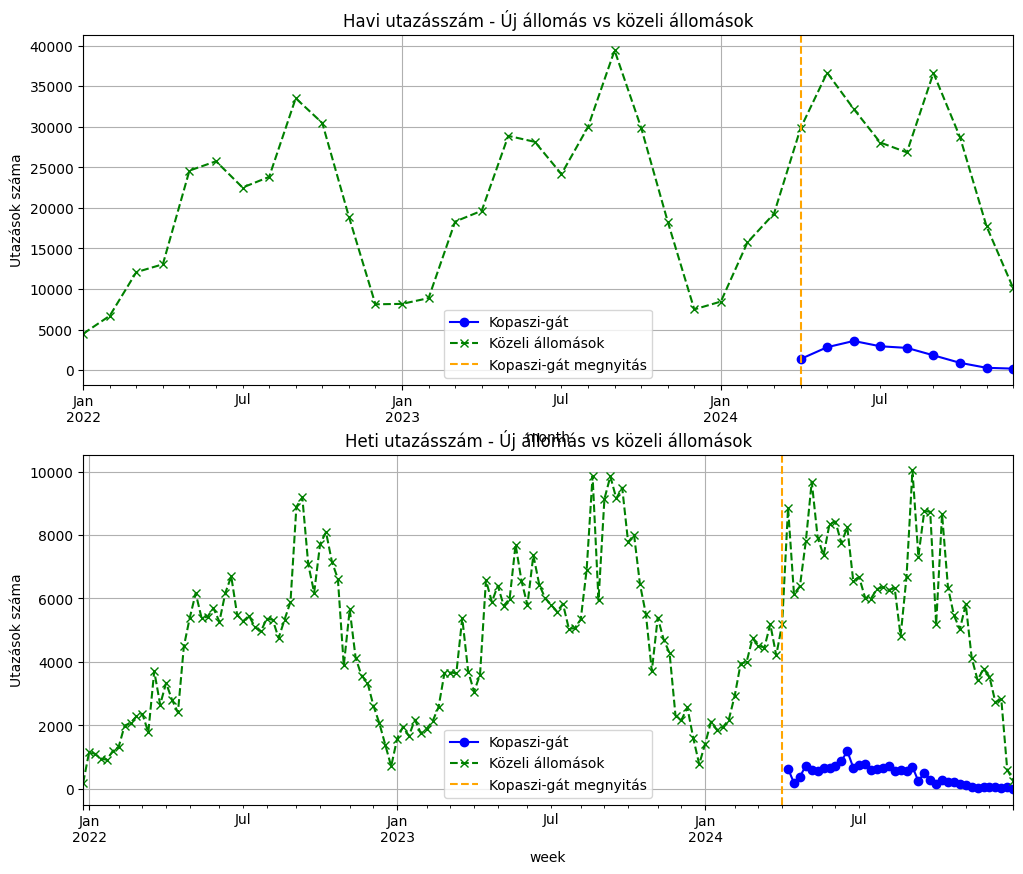

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# --- Célállomás és közeli állomások ---
target_station_id = "1137-Kopaszi-gát"  # teljes azonosító
target_row = df[df['start_place_id'] == target_station_id].head(1)
target_coords = (target_row['start_lat'].iloc[0], target_row['start_lng'].iloc[0])

# Összes állomás + koordináták
start_stations = df[['start_place_id', 'start_lat', 'start_lng']].drop_duplicates()
start_stations.columns = ['station_name', 'lat', 'lng']
end_stations = df[['end_place_id', 'end_lat', 'end_lng']].drop_duplicates()
end_stations.columns = ['station_name', 'lat', 'lng']
all_stations = pd.concat([start_stations, end_stations]).drop_duplicates(subset=['station_name'])
all_stations = all_stations[~all_stations['station_name'].str.startswith(("BIKE", "recording"))]

# Távolság a célállomástól
all_stations['distance_to_target'] = all_stations.apply(
    lambda row: geodesic(target_coords, (row['lat'], row['lng'])).km, axis=1
)

# 15 legközelebbi állomás kiválasztása
nearest_stations = all_stations.nsmallest(15, 'distance_to_target')['station_name'].tolist()

# --- Időoszlopok ---
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['month'] = df['start_time'].dt.to_period('M')
df['week'] = df['start_time'].dt.to_period('W')

# --- Új állomás forgalma ---
target_df = df[(df['start_place_id'] == target_station_id) | (df['end_place_id'] == target_station_id)]
monthly_target = target_df.groupby('month').size()
weekly_target = target_df.groupby('week').size()

# --- Közeli állomások forgalma ---
nearby_df = df[df['start_place_id'].isin(nearest_stations) | df['end_place_id'].isin(nearest_stations)]
monthly_nearby = nearby_df.groupby('month').size()
weekly_nearby = nearby_df.groupby('week').size()

# Átalakítás timestamp-re a grafikonhoz
monthly_target.index = monthly_target.index.to_timestamp()
monthly_nearby.index = monthly_nearby.index.to_timestamp()
weekly_target.index = weekly_target.index.to_timestamp()
weekly_nearby.index = weekly_nearby.index.to_timestamp()

# --- Grafikonok ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Havi bontás
monthly_target.plot(ax=axs[0], marker='o', linestyle='-', color='blue', label='Kopaszi-gát')
monthly_nearby.plot(ax=axs[0], marker='x', linestyle='--', color='green', label='Közeli állomások')
axs[0].axvline(pd.Timestamp('2024-04-01'), color='orange', linestyle='--', label='Kopaszi-gát megnyitás')
axs[0].set_title("Havi utazásszám - Új állomás vs közeli állomások")
axs[0].set_ylabel("Utazások száma")
axs[0].legend()
axs[0].grid(True)

# Heti bontás
weekly_target.plot(ax=axs[1], marker='o', linestyle='-', color='blue', label='Kopaszi-gát')
weekly_nearby.plot(ax=axs[1], marker='x', linestyle='--', color='green', label='Közeli állomások')
axs[1].axvline(pd.Timestamp('2024-04-01'), color='orange', linestyle='--', label='Kopaszi-gát megnyitás')
axs[1].set_title("Heti utazásszám - Új állomás vs közeli állomások")  
axs[1].set_ylabel("Utazások száma")
axs[1].legend()
axs[1].grid(True)



In [92]:
import folium
import pandas as pd

station_id = "1406-Egressy út - Stefánia út"
open_date = pd.to_datetime("2023-06-01")

# Nyitás utáni 90 nap
after = df[(df['start_time'] >= open_date) & 
           (df['start_time'] < open_date + pd.Timedelta(days=90))]

# Csak az utazások az új állomás felé
arrivals = after[after['end_place_id'] == station_id]

# Induló állomások csoportosítása és darabszám
start_counts = arrivals.groupby(['start_place_id','start_lat','start_lng']).size().reset_index(name='count')

# Új állomás koordinátái
station_lat = arrivals['end_lat'].iloc[0]
station_lng = arrivals['end_lng'].iloc[0]

# Alap térkép középpontja az új állomás
m = folium.Map(location=[station_lat, station_lng], zoom_start=13)

# Új állomás jelölése
folium.CircleMarker(
    location=[station_lat, station_lng],
    radius=10,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.8,
    popup=station_id
).add_to(m)

# Induló állomások és vonalak hozzáadása
for _, row in start_counts.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=3 + row['count']/200,  # a pont mérete arányos a forgalommal
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"{row['start_place_id']}: {row['count']} utazás"
    ).add_to(m)
    
    folium.PolyLine(
        locations=[[row['start_lat'], row['start_lng']], [station_lat, station_lng]],
        weight=1 + row['count']/200,
        color='green',
        opacity=0.5
    ).add_to(m)

# Térkép megjelenítése
m


In [24]:
import folium
import pandas as pd

# --- 1️⃣ Állomáscsoport és nyitási dátum ---
zuglo_stations = [
    "1406-Egressy út - Stefánia út",
    "1407-Stefánia út - Thököly út",
    "1408-Zugló vasútállomás",
    "1409-Kacsóh Pongrác út",
    "1410-Papp László Budapest Sportaréna",
    "1411-Reiner Frigyes park"
]

open_date = pd.to_datetime("2023-06-01")

# --- 2️⃣ Csak a nyitás utáni 90 nap ---
after = df[(df['start_time'] >= open_date) & 
           (df['start_time'] < open_date + pd.Timedelta(days=90))].copy()

# --- 3️⃣ Alaptérkép: középpont a zuglói állomások közepe ---
zuglo_coords = df[df['end_place_id'].isin(zuglo_stations)][['end_lat','end_lng']].dropna()
center_lat = zuglo_coords['end_lat'].mean()
center_lng = zuglo_coords['end_lng'].mean()

m = folium.Map(location=[center_lat, center_lng], zoom_start=13)

# --- 4️⃣ Színek az állomásokhoz ---
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cadetblue']

# --- 5️⃣ Végigmegyünk minden zuglói állomáson ---
for i, station_id in enumerate(zuglo_stations):
    color = colors[i % len(colors)]
    
    # Csak az adott állomásra érkező utak
    arrivals = after[after['end_place_id'] == station_id]
    if arrivals.empty:
        continue
    
    # Induló állomások és darabszám
    start_counts = arrivals.groupby(['start_place_id','start_lat','start_lng']).size().reset_index(name='count')

    # Célállomás koordinátái
    station_lat = arrivals['end_lat'].iloc[0]
    station_lng = arrivals['end_lng'].iloc[0]

    # Célállomás megjelölése nagyobb ponttal
    folium.CircleMarker(
        location=[station_lat, station_lng],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=f"{station_id}"
    ).add_to(m)

    # Induló pontok és vonalak kirajzolása
    for _, row in start_counts.iterrows():
        folium.CircleMarker(
            location=[row['start_lat'], row['start_lng']],
            radius=3 + row['count']/200,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.5,
            popup=f"{row['start_place_id']}: {row['count']} utazás → {station_id}"
        ).add_to(m)
        
        folium.PolyLine(
            locations=[[row['start_lat'], row['start_lng']], [station_lat, station_lng]],
            weight=1 + row['count']/200,
            color=color,
            opacity=0.4
        ).add_to(m)

# --- 6️⃣ Térkép mentése ---
m.save("zuglo_allomascsoport_forgalom.html")
m


In [27]:
import folium
import pandas as pd

# --- 1️⃣ Zuglói állomáscsoport azonosítók ---
zuglo_stations = [
    "1406-Egressy út - Stefánia út",
    "1407-Stefánia út - Thököly út",
    "1408-Zugló vasútállomás",
    "1409-Kacsóh Pongrác út",
    "1410-Papp László Budapest Sportaréna",
    "1411-Reiner Frigyes park"
]

open_date = pd.to_datetime("2023-06-01")

# --- 2️⃣ Időszakok definiálása ---
before_period = (df['start_time'] >= open_date - pd.Timedelta(days=90)) & (df['start_time'] < open_date)
after_start = open_date
after_end = open_date + pd.Timedelta(days=90)

# --- 3️⃣ Forgalmi összesítés függvény ---
def station_traffic(data):
    start_counts = data.groupby(['start_place_id', 'start_lat', 'start_lng']).size().reset_index(name='count')
    start_counts.rename(columns={'start_place_id':'station_id', 'start_lat':'lat', 'start_lng':'lng'}, inplace=True)
    end_counts = data.groupby(['end_place_id', 'end_lat', 'end_lng']).size().reset_index(name='count')
    end_counts.rename(columns={'end_place_id':'station_id', 'end_lat':'lat', 'end_lng':'lng'}, inplace=True)
    traffic = pd.concat([start_counts, end_counts]).groupby(['station_id','lat','lng'])['count'].sum().reset_index()
    return traffic

# --- 4️⃣ Forgalom a nyitás előtt ---
before_traffic = station_traffic(df[before_period])

# --- 5️⃣ Forgalom a nyitás után ---
after_data = df[(df['start_time'] >= after_start) & (df['start_time'] < after_end)].copy()

# Ha nincs adat július–augusztusra, pótoljuk szeptemberi forgalommal
missing_months = after_data['start_time'].dt.month.isin([7,8]) & (after_data['start_time'].dt.year==2023)
if missing_months.sum() == 0:
    print("Hiányzó adatok pótlása szeptemberi forgalommal")
    sept_data = df[(df['start_time'] >= pd.to_datetime("2023-09-01")) &
                   (df['start_time'] < pd.to_datetime("2023-10-01"))]
    after_data = pd.concat([after_data, sept_data])

after_traffic = station_traffic(after_data)

# --- 6️⃣ Térkép középpont ---
zuglo_coords = df[df['end_place_id'].isin(zuglo_stations)][['end_lat','end_lng']].dropna()
center_lat = zuglo_coords['end_lat'].mean()
center_lng = zuglo_coords['end_lng'].mean()

# --- 7️⃣ 1. Térkép: megnyitás ELŐTT ---
m_before = folium.Map(location=[center_lat, center_lng], zoom_start=12, tiles="CartoDB positron")

for _, row in before_traffic.iterrows():
    radius = 2 + row['count'] / 500
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=radius,
        color='gray',
        fill=True,
        fill_color='gray',
        fill_opacity=0.6,
        popup=f"{row['station_id']}: {row['count']} utazás (előtte)"
    ).add_to(m_before)

m_before.save("zuglo_elotte_forgalom.html")

# --- 8️⃣ 2. Térkép: megnyitás UTÁN ---
m_after = folium.Map(location=[center_lat, center_lng], zoom_start=12, tiles="CartoDB positron")

for _, row in after_traffic.iterrows():
    color = 'red' if row['station_id'] in zuglo_stations else 'gray'
    radius = 2 + row['count'] / 500
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8 if color == 'red' else 0.6,
        popup=f"{row['station_id']}: {row['count']} utazás (utána)"
    ).add_to(m_after)

m_after.save("zuglo_utana_forgalom.html")

print("✅ Kész! A két térkép mentve lett:")
print("  • zuglo_elotte_forgalom.html  → forgalmas csomópontok a bevezetés előtt")
print("  • zuglo_utana_forgalom.html   → forgalom és gócpontok a bevezetés után")




Hiányzó adatok pótlása szeptemberi forgalommal
✅ Kész! A két térkép mentve lett:
  • zuglo_elotte_forgalom.html  → forgalmas csomópontok a bevezetés előtt
  • zuglo_utana_forgalom.html   → forgalom és gócpontok a bevezetés után


In [30]:
# --- 1️⃣ Előtte/utána összesítés ---
before_counts = before_traffic.groupby('station_id')['count'].sum()
after_counts = after_traffic.groupby('station_id')['count'].sum()

# --- 2️⃣ Különbözet számítása ---
all_stations = sorted(set(before_counts.index).union(set(after_counts.index)))
stats = []

for s in all_stations:
    b = int(before_counts.get(s, 0))
    a = int(after_counts.get(s, 0))
    stats.append({
        'station_id': s,
        'before_count': b,
        'after_count': a,
        'difference': a - b,
        'zuglo_group': s in zuglo_stations
    })

stats_df = pd.DataFrame(stats)

# --- 3️⃣ Rangsorolás és mentés ---
stats_df = stats_df.sort_values(by='after_count', ascending=False)
stats_df.to_csv("zuglo_statisztika.csv", index=False)

print("✅ Táblázat elkészült és mentve: zuglo_statisztika.csv")
stats_df.head(20)



✅ Táblázat elkészült és mentve: zuglo_statisztika.csv


,station_id,before_count,after_count,difference,zuglo_group
166,1301-Jászai Mari tér,30434,27549,-2885,False
169,1304-Margitsziget,30047,26048,-3999,False
91,0812-Corvin sétány,22026,22532,506,False
46,0515-Fővám tér,21289,21053,-236,False
88,0809-Blaha Lujza tér M,19595,20723,1128,False
129,1101-Szent Gellért tér,20242,20438,196,False
109,0905-Kálvin tér,20337,20382,45,False
0,0101-Batthyány tér,19000,19020,20,False
56,0607-Oktogon,18116,18988,872,False
83,0804-Rákóczi tér,17044,17818,774,False


In [31]:
import folium
import pandas as pd

# --- 1️⃣ 9. kerületi állomáscsoport azonosítók ---
kerulet9_stations = [
    "0921-Mester utca - Ferenc körút",
    "0922-Haller utca – Mester utca",
    "0923-Nádasdy utca (játszótér)",
    "0924-Haller utca - Soroksári út"
]

open_date = pd.to_datetime("2023-09-01")  # megnyitás szeptemberben

# --- 2️⃣ Időszakok definiálása ---
before_start = open_date - pd.Timedelta(days=90)
before_end = open_date
after_start = open_date
after_end = open_date + pd.Timedelta(days=90)

# --- 3️⃣ Forgalmi összesítés függvény ---
def station_traffic(data):
    start_counts = data.groupby(['start_place_id', 'start_lat', 'start_lng']).size().reset_index(name='count')
    start_counts.rename(columns={'start_place_id':'station_id', 'start_lat':'lat', 'start_lng':'lng'}, inplace=True)
    end_counts = data.groupby(['end_place_id', 'end_lat', 'end_lng']).size().reset_index(name='count')
    end_counts.rename(columns={'end_place_id':'station_id', 'end_lat':'lat', 'end_lng':'lng'}, inplace=True)
    traffic = pd.concat([start_counts, end_counts]).groupby(['station_id','lat','lng'])['count'].sum().reset_index()
    return traffic

# --- 4️⃣ Forgalom a nyitás előtt ---
before_data = df[(df['start_time'] >= before_start) & (df['start_time'] < before_end)].copy()

# Ha hiányoznak július–augusztusi adatok, pótoljuk júniusi forgalommal
missing_months = before_data['start_time'].dt.month.isin([7,8]) & (before_data['start_time'].dt.year==2023)
if missing_months.sum() == 0:
    print("Hiányzó adatok pótlása júniusi forgalommal")
    june_data = df[(df['start_time'] >= pd.to_datetime("2023-06-01")) &
                   (df['start_time'] < pd.to_datetime("2023-07-01"))]
    before_data = pd.concat([before_data, june_data])

before_traffic = station_traffic(before_data)

# --- 5️⃣ Forgalom a nyitás után ---
after_data = df[(df['start_time'] >= after_start) & (df['start_time'] < after_end)]
after_traffic = station_traffic(after_data)

# --- 6️⃣ Térkép középpont ---
coords = df[df['end_place_id'].isin(kerulet9_stations)][['end_lat','end_lng']].dropna()
center_lat = coords['end_lat'].mean()
center_lng = coords['end_lng'].mean()

# --- 7️⃣ 1. Térkép: megnyitás ELŐTT ---
m_before = folium.Map(location=[center_lat, center_lng], zoom_start=13, tiles="CartoDB positron")
for _, row in before_traffic.iterrows():
    radius = 2 + row['count'] / 500
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=radius,
        color='gray',
        fill=True,
        fill_color='gray',
        fill_opacity=0.6,
        popup=f"{row['station_id']}: {row['count']} utazás (előtte)"
    ).add_to(m_before)
m_before.save("kerulet9_elotte_forgalom.html")

# --- 8️⃣ 2. Térkép: megnyitás UTÁN ---
m_after = folium.Map(location=[center_lat, center_lng], zoom_start=13, tiles="CartoDB positron")
for _, row in after_traffic.iterrows():
    color = 'red' if row['station_id'] in kerulet9_stations else 'gray'
    radius = 2 + row['count'] / 500
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8 if color=='red' else 0.6,
        popup=f"{row['station_id']}: {row['count']} utazás (utána)"
    ).add_to(m_after)
m_after.save("kerulet9_utana_forgalom.html")

print("✅ Kész! A két térkép mentve lett:")
print("  • kerulet9_elotte_forgalom.html  → forgalmas csomópontok a bevezetés előtt")
print("  • kerulet9_utana_forgalom.html   → forgalom és gócpontok a bevezetés után")


Hiányzó adatok pótlása júniusi forgalommal
✅ Kész! A két térkép mentve lett:
  • kerulet9_elotte_forgalom.html  → forgalmas csomópontok a bevezetés előtt
  • kerulet9_utana_forgalom.html   → forgalom és gócpontok a bevezetés után


In [32]:
# --- 1️⃣ Előtte/utána összesítés ---
before_counts = before_traffic.groupby('station_id')['count'].sum()
after_counts = after_traffic.groupby('station_id')['count'].sum()

# --- 2️⃣ Különbözet számítása ---
all_stations = sorted(set(before_counts.index).union(set(after_counts.index)))
stats = []

for s in all_stations:
    b = int(before_counts.get(s, 0))
    a = int(after_counts.get(s, 0))
    stats.append({
        'station_id': s,
        'before_count': b,
        'after_count': a,
        'difference': a - b,
        'kerulet9_group': s in kerulet9_stations  # módosítva a 9. kerületre
    })

stats_df = pd.DataFrame(stats)

# --- 3️⃣ Rangsorolás és mentés ---
stats_df = stats_df.sort_values(by='after_count', ascending=False)
stats_df.to_csv("kerulet9_statisztika.csv", index=False)

print("✅ Táblázat elkészült és mentve: kerulet9_statisztika.csv")
stats_df.head(20)


✅ Táblázat elkészült és mentve: kerulet9_statisztika.csv


,station_id,before_count,after_count,difference,kerulet9_group
166,1301-Jászai Mari tér,26533,29034,2501,False
91,0812-Corvin sétány,19259,28843,9584,False
88,0809-Blaha Lujza tér M,18361,27197,8836,False
109,0905-Kálvin tér,18537,24650,6113,False
46,0515-Fővám tér,18693,24500,5807,False
169,1304-Margitsziget,26955,24346,-2609,False
129,1101-Szent Gellért tér,17094,24031,6937,False
110,0906-Ferenc tér,14916,22027,7111,False
83,0804-Rákóczi tér,15539,22019,6480,False
56,0607-Oktogon,18729,21705,2976,False


In [33]:
import folium
import pandas as pd

# --- 1️⃣ Állomás azonosító ---
kopaszi_station = ["1137-Kopaszi-gát"]

open_date = pd.to_datetime("2024-04-01")

# --- 2️⃣ Időszakok definiálása ---
before_period = (df['start_time'] >= open_date - pd.Timedelta(days=90)) & (df['start_time'] < open_date)
after_start = open_date
after_end = open_date + pd.Timedelta(days=90)

# --- 3️⃣ Forgalmi összesítés függvény ---
def station_traffic(data):
    start_counts = data.groupby(['start_place_id', 'start_lat', 'start_lng']).size().reset_index(name='count')
    start_counts.rename(columns={'start_place_id':'station_id', 'start_lat':'lat', 'start_lng':'lng'}, inplace=True)
    end_counts = data.groupby(['end_place_id', 'end_lat', 'end_lng']).size().reset_index(name='count')
    end_counts.rename(columns={'end_place_id':'station_id', 'end_lat':'lat', 'end_lng':'lng'}, inplace=True)
    traffic = pd.concat([start_counts, end_counts]).groupby(['station_id','lat','lng'])['count'].sum().reset_index()
    return traffic

# --- 4️⃣ Forgalom a nyitás előtt ---
before_data = df[before_period].copy()

# Ha nincs adat február–márciusra, pótoljuk januári adatokkal
missing_months = before_data['start_time'].dt.month.isin([2,3]) & (before_data['start_time'].dt.year==2024)
if missing_months.sum() == 0:
    jan_data = df[(df['start_time'] >= pd.to_datetime("2024-01-01")) &
                  (df['start_time'] < pd.to_datetime("2024-02-01"))]
    before_data = pd.concat([before_data, jan_data])

before_traffic = station_traffic(before_data)

# --- 5️⃣ Forgalom a nyitás után ---
after_data = df[(df['start_time'] >= after_start) & (df['start_time'] < after_end)].copy()
after_traffic = station_traffic(after_data)

# --- 6️⃣ Térkép középpont ---
station_coords = df[df['end_place_id'].isin(kopaszi_station)][['end_lat','end_lng']].dropna()
center_lat = station_coords['end_lat'].mean()
center_lng = station_coords['end_lng'].mean()

# --- 7️⃣ 1. Térkép: ELŐTTE ---
m_before = folium.Map(location=[center_lat, center_lng], zoom_start=13, tiles="CartoDB positron")
for _, row in before_traffic.iterrows():
    radius = 2 + row['count'] / 500
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=radius,
        color='gray',
        fill=True,
        fill_color='gray',
        fill_opacity=0.6,
        popup=f"{row['station_id']}: {row['count']} utazás (előtte)"
    ).add_to(m_before)
m_before.save("kopaszi_elotte_forgalom.html")

# --- 8️⃣ 2. Térkép: UTÁN ---
m_after = folium.Map(location=[center_lat, center_lng], zoom_start=13, tiles="CartoDB positron")
for _, row in after_traffic.iterrows():
    color = 'red' if row['station_id'] in kopaszi_station else 'gray'
    radius = 2 + row['count'] / 500
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8 if color == 'red' else 0.6,
        popup=f"{row['station_id']}: {row['count']} utazás (utána)"
    ).add_to(m_after)
m_after.save("kopaszi_utana_forgalom.html")

print("✅ Kész! A két térkép mentve lett:")
print("  • kopaszi_elotte_forgalom.html")
print("  • kopaszi_utana_forgalom.html")


✅ Kész! A két térkép mentve lett:
  • kopaszi_elotte_forgalom.html
  • kopaszi_utana_forgalom.html


In [34]:
# --- 1️⃣ Előtte/utána összesítés ---
before_counts = before_traffic.groupby('station_id')['count'].sum()
after_counts = after_traffic.groupby('station_id')['count'].sum()

# --- 2️⃣ Különbözet számítása ---
all_stations = sorted(set(before_counts.index).union(set(after_counts.index)))
stats = []

for s in all_stations:
    b = int(before_counts.get(s, 0))
    a = int(after_counts.get(s, 0))
    stats.append({
        'station_id': s,
        'before_count': b,
        'after_count': a,
        'difference': a - b,
        'kopaszi_group': s in kopaszi_station
    })

stats_df = pd.DataFrame(stats)

# --- 3️⃣ Rangsorolás és mentés ---
stats_df = stats_df.sort_values(by='after_count', ascending=False)
stats_df.to_csv("kopaszi_statisztika.csv", index=False)

print("✅ Táblázat elkészült: kopaszi_statisztika.csv")
stats_df.head(20)


✅ Táblázat elkészült: kopaszi_statisztika.csv


,station_id,before_count,after_count,difference,kopaszi_group
177,1304-Margitsziget,15664,46177,30513,False
174,1301-Jászai Mari tér,16384,43753,27369,False
46,0515-Fővám tér,12854,32955,20101,False
110,0905-Kálvin tér,14062,31759,17697,False
89,0809-Blaha Lujza tér M,15116,31738,16622,False
92,0812-Corvin sétány,16177,30049,13872,False
131,1101-Szent Gellért tér,13245,29914,16669,False
0,0101-Batthyány tér,11871,28590,16719,False
181,1308-Hajós Alfréd Uszoda,10071,25334,15263,False
84,0804-Rákóczi tér,12049,25044,12995,False


In [35]:
import folium
import pandas as pd

# --- 1️⃣ Állomás azonosító ---
westend_station = ["0620-Westend - Balzac utca"]

open_date = pd.to_datetime("2024-05-01")

# --- 2️⃣ Időszakok definiálása ---
before_period = (df['start_time'] >= open_date - pd.Timedelta(days=90)) & (df['start_time'] < open_date)
after_start = open_date
after_end = open_date + pd.Timedelta(days=90)

# --- 3️⃣ Forgalmi összesítés függvény ---
def station_traffic(data):
    start_counts = data.groupby(['start_place_id', 'start_lat', 'start_lng']).size().reset_index(name='count')
    start_counts.rename(columns={'start_place_id':'station_id', 'start_lat':'lat', 'start_lng':'lng'}, inplace=True)
    end_counts = data.groupby(['end_place_id', 'end_lat', 'end_lng']).size().reset_index(name='count')
    end_counts.rename(columns={'end_place_id':'station_id', 'end_lat':'lat', 'end_lng':'lng'}, inplace=True)
    traffic = pd.concat([start_counts, end_counts]).groupby(['station_id','lat','lng'])['count'].sum().reset_index()
    return traffic

# --- 4️⃣ Forgalom a nyitás előtt ---
before_data = df[before_period].copy()

# Ha nincs adat március–áprilisra, pótoljuk áprilisi adatokkal
missing_months = before_data['start_time'].dt.month.isin([3,4]) & (before_data['start_time'].dt.year==2024)
if missing_months.sum() == 0:
    apr_data = df[(df['start_time'] >= pd.to_datetime("2024-04-01")) &
                  (df['start_time'] < pd.to_datetime("2024-05-01"))]
    before_data = pd.concat([before_data, apr_data])

before_traffic = station_traffic(before_data)

# --- 5️⃣ Forgalom a nyitás után ---
after_data = df[(df['start_time'] >= after_start) & (df['start_time'] < after_end)].copy()
after_traffic = station_traffic(after_data)

# --- 6️⃣ Térkép középpont ---
station_coords = df[df['end_place_id'].isin(westend_station)][['end_lat','end_lng']].dropna()
center_lat = station_coords['end_lat'].mean()
center_lng = station_coords['end_lng'].mean()

# --- 7️⃣ 1. Térkép: ELŐTTE ---
m_before = folium.Map(location=[center_lat, center_lng], zoom_start=13, tiles="CartoDB positron")
for _, row in before_traffic.iterrows():
    radius = 2 + row['count'] / 500
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=radius,
        color='gray',
        fill=True,
        fill_color='gray',
        fill_opacity=0.6,
        popup=f"{row['station_id']}: {row['count']} utazás (előtte)"
    ).add_to(m_before)
m_before.save("westend_elotte_forgalom.html")

# --- 8️⃣ 2. Térkép: UTÁN ---
m_after = folium.Map(location=[center_lat, center_lng], zoom_start=13, tiles="CartoDB positron")
for _, row in after_traffic.iterrows():
    color = 'red' if row['station_id'] in westend_station else 'gray'
    radius = 2 + row['count'] / 500
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8 if color == 'red' else 0.6,
        popup=f"{row['station_id']}: {row['count']} utazás (utána)"
    ).add_to(m_after)
m_after.save("westend_utana_forgalom.html")

print("✅ Kész! A két térkép mentve lett:")
print("  • westend_elotte_forgalom.html")
print("  • westend_utana_forgalom.html")


✅ Kész! A két térkép mentve lett:
  • westend_elotte_forgalom.html
  • westend_utana_forgalom.html


In [36]:
# --- 1️⃣ Előtte/utána összesítés ---
before_counts = before_traffic.groupby('station_id')['count'].sum()
after_counts = after_traffic.groupby('station_id')['count'].sum()

# --- 2️⃣ Különbözet számítása ---
all_stations = sorted(set(before_counts.index).union(set(after_counts.index)))
stats = []

for s in all_stations:
    b = int(before_counts.get(s, 0))
    a = int(after_counts.get(s, 0))
    stats.append({
        'station_id': s,
        'before_count': b,
        'after_count': a,
        'difference': a - b,
        'westend_group': s in westend_station
    })

stats_df = pd.DataFrame(stats)

# --- 3️⃣ Rangsorolás és mentés ---
stats_df = stats_df.sort_values(by='after_count', ascending=False)
stats_df.to_csv("westend_statisztika.csv", index=False)

print("✅ Táblázat elkészült: westend_statisztika.csv")
stats_df.head(20)


✅ Táblázat elkészült: westend_statisztika.csv


,station_id,before_count,after_count,difference,westend_group
178,1304-Margitsziget,28097,44834,16737,False
175,1301-Jászai Mari tér,27314,42427,15113,False
90,0809-Blaha Lujza tér M,21568,32873,11305,False
46,0515-Fővám tér,20775,31346,10571,False
93,0812-Corvin sétány,21068,30975,9907,False
111,0905-Kálvin tér,20930,30939,10009,False
132,1101-Szent Gellért tér,20487,28857,8370,False
0,0101-Batthyány tér,18251,27966,9715,False
85,0804-Rákóczi tér,16749,25307,8558,False
182,1308-Hajós Alfréd Uszoda,16543,25011,8468,False


In [37]:
import folium
import pandas as pd

# --- 1️⃣ Állomás azonosító ---
csonka_station = ["1128-Csonka János tér"]

open_date = pd.to_datetime("2022-06-01")

# --- 2️⃣ Időszakok definiálása ---
before_period = (df['start_time'] >= open_date - pd.Timedelta(days=90)) & (df['start_time'] < open_date)
after_start = open_date
after_end = open_date + pd.Timedelta(days=90)

# --- 3️⃣ Forgalmi összesítés függvény ---
def station_traffic(data):
    start_counts = data.groupby(['start_place_id', 'start_lat', 'start_lng']).size().reset_index(name='count')
    start_counts.rename(columns={'start_place_id':'station_id', 'start_lat':'lat', 'start_lng':'lng'}, inplace=True)
    end_counts = data.groupby(['end_place_id', 'end_lat', 'end_lng']).size().reset_index(name='count')
    end_counts.rename(columns={'end_place_id':'station_id', 'end_lat':'lat', 'end_lng':'lng'}, inplace=True)
    traffic = pd.concat([start_counts, end_counts]).groupby(['station_id','lat','lng'])['count'].sum().reset_index()
    return traffic

# --- 4️⃣ Forgalom a nyitás előtt ---
before_data = df[before_period].copy()

# Ha nincs adat április–májusra, pótoljuk májusi adatokkal
missing_months = before_data['start_time'].dt.month.isin([4,5]) & (before_data['start_time'].dt.year==2022)
if missing_months.sum() == 0:
    may_data = df[(df['start_time'] >= pd.to_datetime("2022-05-01")) &
                  (df['start_time'] < pd.to_datetime("2022-06-01"))]
    before_data = pd.concat([before_data, may_data])

before_traffic = station_traffic(before_data)

# --- 5️⃣ Forgalom a nyitás után ---
after_data = df[(df['start_time'] >= after_start) & (df['start_time'] < after_end)].copy()
after_traffic = station_traffic(after_data)

# --- 6️⃣ Térkép középpont ---
station_coords = df[df['end_place_id'].isin(csonka_station)][['end_lat','end_lng']].dropna()
center_lat = station_coords['end_lat'].mean()
center_lng = station_coords['end_lng'].mean()

# --- 7️⃣ 1. Térkép: ELŐTTE ---
m_before = folium.Map(location=[center_lat, center_lng], zoom_start=13, tiles="CartoDB positron")
for _, row in before_traffic.iterrows():
    radius = 2 + row['count'] / 500
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=radius,
        color='gray',
        fill=True,
        fill_color='gray',
        fill_opacity=0.6,
        popup=f"{row['station_id']}: {row['count']} utazás (előtte)"
    ).add_to(m_before)
m_before.save("csonka_elotte_forgalom.html")

# --- 8️⃣ 2. Térkép: UTÁN ---
m_after = folium.Map(location=[center_lat, center_lng], zoom_start=13, tiles="CartoDB positron")
for _, row in after_traffic.iterrows():
    color = 'red' if row['station_id'] in csonka_station else 'gray'
    radius = 2 + row['count'] / 500
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8 if color == 'red' else 0.6,
        popup=f"{row['station_id']}: {row['count']} utazás (utána)"
    ).add_to(m_after)
m_after.save("csonka_utana_forgalom.html")

print("✅ Kész! A két térkép mentve lett:")
print("  • csonka_elotte_forgalom.html")
print("  • csonka_utana_forgalom.html")



✅ Kész! A két térkép mentve lett:
  • csonka_elotte_forgalom.html
  • csonka_utana_forgalom.html


In [38]:
# --- 1️⃣ Előtte/utána összesítés ---
before_counts = before_traffic.groupby('station_id')['count'].sum()
after_counts = after_traffic.groupby('station_id')['count'].sum()

# --- 2️⃣ Különbözet számítása ---
all_stations = sorted(set(before_counts.index).union(set(after_counts.index)))
stats = []

for s in all_stations:
    b = int(before_counts.get(s, 0))
    a = int(after_counts.get(s, 0))
    stats.append({
        'station_id': s,
        'before_count': b,
        'after_count': a,
        'difference': a - b,
        'csonka_group': s in csonka_station
    })

stats_df = pd.DataFrame(stats)

# --- 3️⃣ Rangsorolás és mentés ---
stats_df = stats_df.sort_values(by='after_count', ascending=False)
stats_df.to_csv("csonka_statisztika.csv", index=False)

print("✅ Táblázat elkészült: csonka_statisztika.csv")
stats_df.head(20)


✅ Táblázat elkészült: csonka_statisztika.csv


,station_id,before_count,after_count,difference,csonka_group
148,1301-Jászai Mari tér,29021,40762,11741,False
151,1304-Margitsziget,27676,39845,12169,False
80,0812-Corvin sétány,20445,32257,11812,False
39,0515-Fővám tér,21187,30600,9413,False
72,0804-Rákóczi tér,16292,26924,10632,False
96,0905-Kálvin tér,18957,26616,7659,False
111,1101-Szent Gellért tér,19374,26299,6925,False
49,0607-Oktogon,15860,25424,9564,False
95,0904-Boráros tér,15246,24767,9521,False
0,0101-Batthyány tér,17161,23724,6563,False


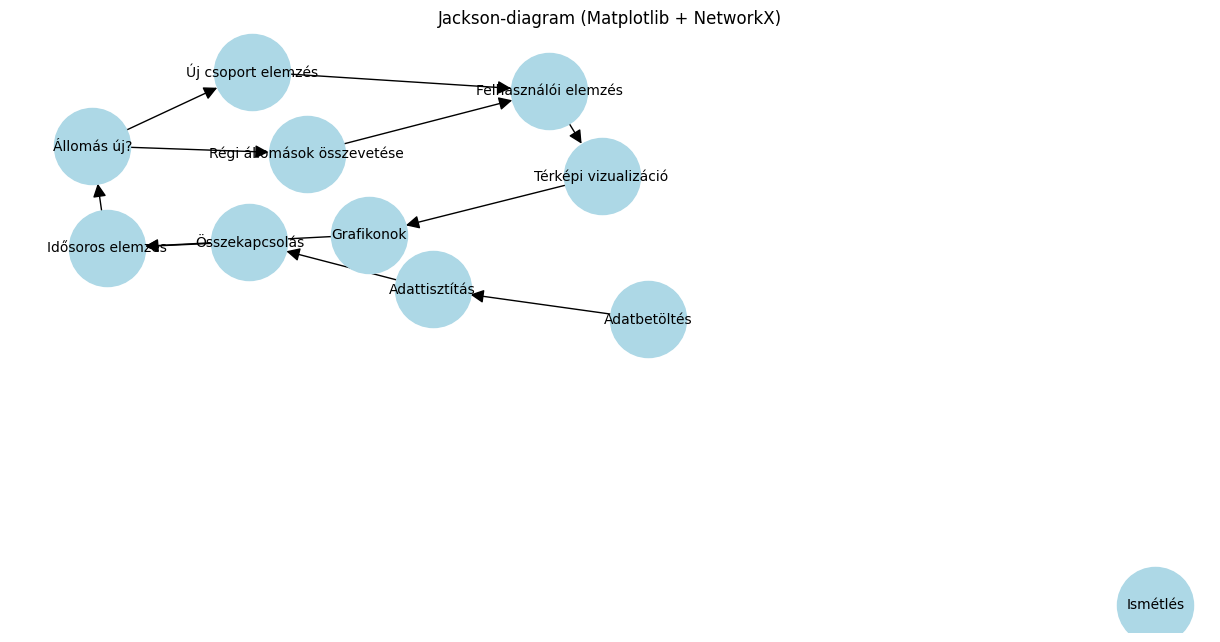

In [40]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

# Node-ok
nodes = ["Adatbetöltés","Adattisztítás","Összekapcsolás","Idősoros elemzés",
         "Állomás új?","Új csoport elemzés","Régi állomások összevetése",
         "Felhasználói elemzés","Térképi vizualizáció","Grafikonok","Ismétlés"]

for node in nodes:
    G.add_node(node)

# Élek (szekvencia és elágazás)
edges = [("Adatbetöltés","Adattisztítás"),
         ("Adattisztítás","Összekapcsolás"),
         ("Összekapcsolás","Idősoros elemzés"),
         ("Idősoros elemzés","Állomás új?"),
         ("Állomás új?","Új csoport elemzés"),
         ("Állomás új?","Régi állomások összevetése"),
         ("Új csoport elemzés","Felhasználói elemzés"),
         ("Régi állomások összevetése","Felhasználói elemzés"),
         ("Felhasználói elemzés","Térképi vizualizáció"),
         ("Térképi vizualizáció","Grafikonok"),
         ("Grafikonok","Idősoros elemzés")]  # Iteráció

G.add_edges_from(edges)

plt.figure(figsize=(12,6))
pos = nx.spring_layout(G, seed=42)  # automatikus elrendezés
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, arrowsize=20, font_size=10)
plt.title("Jackson-diagram (Matplotlib + NetworkX)")
plt.show()


In [45]:
import pandas as pd

# Adatok definiálása
data = {
    "Állomás/Állomáscsoport": [
        "Csonka János tér",
        "Zuglói állomások",
        "9. kerületi állomások",
        "Kopaszi-gát",
        "Westend – Balzac utca"
    ],
    "Nyitás időpontja": [
        "2022 június",
        "2023 június",
        "2023 szeptember",
        "2024 április",
        "2024 május"
    ],
    "Terület sűrűsége": [
        "Központi",
        "Közepesen telített",
        "Kevésbé telített",
        "Kevésbé telített",
        "Sűrűn ellátott"
    ],
    "Új felhasználók aránya": [
        "36,7 %",
        "31,5 %",
        "39,3 %",
        "50,1 %",
        "30,1 %"
    ],
    "Összesített forgalom növekedés": [
        "Mérsékelt",
        "92 felhasználó ",
        "3 120 felhasználó",
        "2 859 felhasználó",
        "1 912 felhasználó"
    ],
    "Fő hatás típusa": [
        "Meglévők aktivitása",
        "Forgalom átrendezés",
        "Új felhasználók bevonzása",
        "Új felhasználók bevonzása",
        "Meglévők aktivitása"
    ]
}

# DataFrame létrehozása
df = pd.DataFrame(data)

# DataFrame megjelenítése
df



,Állomás/Állomáscsoport,Nyitás időpontja,Terület sűrűsége,Új felhasználók aránya,Összesített forgalom növekedés,Fő hatás típusa
0,Csonka János tér,2022 június,Központi,"36,7 %",Mérsékelt,Meglévők aktivitása
1,Zuglói állomások,2023 június,Közepesen telített,"31,5 %",92 felhasználó,Forgalom átrendezés
2,9. kerületi állomások,2023 szeptember,Kevésbé telített,"39,3 %",3 120 felhasználó,Új felhasználók bevonzása
3,Kopaszi-gát,2024 április,Kevésbé telített,"50,1 %",2 859 felhasználó,Új felhasználók bevonzása
4,Westend – Balzac utca,2024 május,Sűrűn ellátott,"30,1 %",1 912 felhasználó,Meglévők aktivitása
